## 0. Import packages and define functions 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from skimage import io,restoration
from tifffile import imsave
from tqdm import tqdm
from time import time
from skimage import exposure,segmentation,morphology,measure,filters
from skimage.measure import block_reduce
from skimage.feature import peak_local_max
from skimage import filters
from math import ceil
from scipy.ndimage import zoom
from scipy import ndimage as ndi
import cv2
import glob
import os
from PIL import ImageFilter

In [2]:
#### Define some useful functions

# Visualization functions

def image_show(image, nrows=1, ncols=1, cmap='gray',size = 8):
    """show 2D image in grayscale.
    """
    
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(size, size))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    
    plt.show();
    return fig, ax

def vimg_show(volume):
    """show the center level (2D image) of a 3D volume.
    """
    
    image_show(volume[volume.shape[0]//2])
    
# Different ways to fill holes in a 2D image

def fill_hole_add_edge(img, edge_size = 2, set_edge_val = 255):
    """fill holes in a 2D image when 
    the four edges are one-by-one considered as forground.
    
    Args:
    img: the 2D image (numpy array)
    edge_size: the width of edge
    set_edge_val: the intensity of foreground
    
    Returns:
    the 2D image after filling-hole (numpy array)
    """
    
    #record original 4 edges
    top_edge = img[:edge_size,:]#top
    bottom_edge = img[-edge_size:,:]#bottom
    right_edge = img[:,-edge_size:]#right
    left_edge = img[:,:edge_size]#left
        
    #top
    img_edge = np.copy(img)
    img_edge[:edge_size,:] = set_edge_val #top 
    img_edge = ndi.morphology.binary_fill_holes(img_edge)
    
    #right
    img_edge[:edge_size,:] = top_edge #top set back
    img_edge[:,-edge_size:] = set_edge_val #right
    img_edge = ndi.morphology.binary_fill_holes(img_edge)
    
    #bottom
    img_edge[:,-edge_size:] = right_edge #right set back
    img_edge[-edge_size:,:] = set_edge_val #bottom
    img_edge = ndi.morphology.binary_fill_holes(img_edge)
    
    #left
    img_edge[-edge_size:,:] = bottom_edge #bottom set back
    img_edge[:,:edge_size] = set_edge_val
    img_edge = ndi.morphology.binary_fill_holes(img_edge)
    
    #set back all edges
    img_edge[:,:edge_size] = left_edge #left set back

    return img_edge
    

def fill_hole_2edge_2corner(img, edge_size = 2, set_edge_val = 255): #long biopsy version
    """fill holes in a 2D image when 
    the opposing edges/corners are one-by-one considered as forground.
    
    Args:
    img: the 2D image (numpy array)
    edge_size: the width of edge
    set_edge_val: the intensity of foreground
    
    Returns:
    the 2D image after filling-hole (numpy array)
    """
    
    #record original 4 edges
    top_edge = img[:edge_size,:]#top
    bottom_edge = img[-edge_size:,:]#bottom
    right_edge = img[:,-edge_size:]#right
    left_edge = img[:,:edge_size]#left
    
    h, w = img.shape 
    short_edge_len = min(h,w)
    
    #1 top & bottom
    img_edge = np.copy(img)
    img_edge[:edge_size,:] = set_edge_val #top 
    img_edge[-edge_size:,:] = set_edge_val #bottom
    img_edge = ndi.morphology.binary_fill_holes(img_edge)

    #2 top right corner & bottom left corner
    img_edge[:edge_size,:] = top_edge #top set back
    img_edge[:edge_size,short_edge_len//2:] = set_edge_val #top right half
    img_edge[:short_edge_len//2,-edge_size:] = set_edge_val #right top half
    img_edge[-edge_size:,:] = bottom_edge #bottom set back
    img_edge[-edge_size:,:short_edge_len//2] = set_edge_val #bottom left half
    img_edge[short_edge_len//2:,:edge_size] = set_edge_val #left bottom half
    img_edge = ndi.morphology.binary_fill_holes(img_edge)
    
    #3 right and left
    img_edge[:edge_size,:] = top_edge # top set back
    img_edge[:,-edge_size:] = set_edge_val # right
    img_edge[-edge_size:,:] = bottom_edge # bottom set back
    img_edge[:,:edge_size] = set_edge_val # left
    img_edge = ndi.morphology.binary_fill_holes(img_edge)
    
    #4 bottom right corner & top left corner
    img_edge[:edge_size,:short_edge_len//2] = set_edge_val # top left half
    img_edge[:,-edge_size:] = right_edge # right set back
    img_edge[short_edge_len//2:,-edge_size:] = set_edge_val # right bottom half
    img_edge[-edge_size:,short_edge_len//2:] = set_edge_val # bottom right half
    img_edge[:,:edge_size] = left_edge # left set back
    img_edge[:short_edge_len//2,:edge_size] = set_edge_val # left top half
    img_edge = ndi.morphology.binary_fill_holes(img_edge)
    
    #5 set back all edges
    img_edge[:edge_size,:] = top_edge #top set back
    img_edge[:,-edge_size:] = right_edge # right set back
    img_edge[-edge_size:,:] = bottom_edge # bottom set back
    img_edge[:,:edge_size] = left_edge #left set back

    return img_edge

## 1. Obtain preliminary luminal epithelium mask with synthetic CK8

In [3]:
# Specify image stack info

block_name = 's140a'

full_seq_dir = 'Z:\\WX\\WX_test_dod\\whobio_sets\\vid2vid_results\\'+block_name[:-1]+'_o\\full_seq'
#contains the CK8 tif file and a folder named 'Fused_dod_sxxx' which contains 'ch2' folder (the cytoplasm tif)

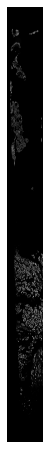

(727, 12544, 1024)


In [4]:
#### Import CK8 image stack

stack_dir = full_seq_dir+'\\Fused_dod_'+block_name+'.tif'
stack = io.imread(stack_dir)

image_show(stack[stack.shape[0]//2]); #check the center level of 3D CK8 image
print(stack.shape)

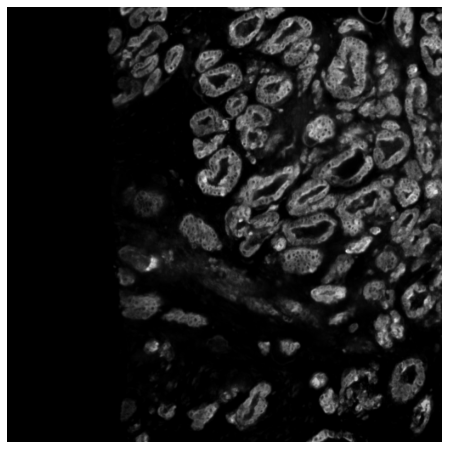

time for pooling: 69.462952
(364, 6272, 512)
uint8


In [5]:
#### Downsample CK8 image by mean-pooling

# Create an initial path to store the results
stack_path = full_seq_dir+'\\Fused_dod_'+block_name+'\\dod_'+block_name
if not os.path.exists(os.path.dirname(stack_path)):
    os.makedirs(os.path.dirname(stack_path))

# Downsample CK8 image by 2X in 3 directions
ds_time = 2
t0 = time()
stack_ds = block_reduce(stack, block_size=(ds_time, ds_time, ds_time), func=np.mean)
image_show(stack_ds[stack_ds.shape[0]//2][4312:4824,:])
t1 = time()
print('time for pooling: %f' %(t1 - t0))

# Correct dynamic range [optional]
if np.amax(stack_ds)<2:
    stack_ds = (stack_ds*255)
stack_ds = stack_ds.astype(np.uint8)

# Adjust background level [optional]
low_thrsh = 5
high_thrsh = 255
stack_ds = ((np.clip(stack_ds, low_thrsh, high_thrsh)- low_thrsh)/(high_thrsh-low_thrsh)*255).astype(np.uint8)
print(stack_ds.shape)
print(stack_ds.dtype)

# Save the downsampled CK8 image
imsave(stack_path +'_ds'+ str(ds_time) + '.tif',stack_ds[:,4312:4824,:])

del stack #once downsampled, free memory by deleting the original-resolution image

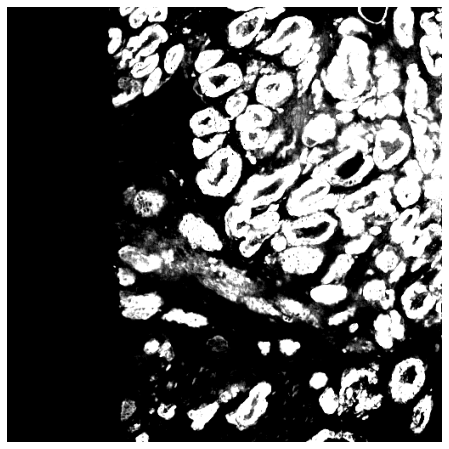

In [6]:
#### Enhance features prior to thresholding

# Define the kernel for convolution
kernel_sharpening = np.array([[-1,-1,-1], 
                              [-1,18,-1],
                              [-1,-1,-1]]) # Raise overall intensity and bring up edges

# Enhance features level by level
stack_edgenh = np.zeros(stack_ds.shape,dtype = np.uint8)
for frame_idx in range(len(stack_ds)):
    stack_edgenh[frame_idx] = cv2.filter2D(stack_ds[frame_idx], -1, kernel_sharpening)

# Save feature-enhanced CK8 images    
image_show(stack_edgenh[stack_edgenh.shape[0]//2][4312:4824,:])
imsave(stack_path +'_edgenh.tif',stack_edgenh[:,4312:4824,:])

100%|████████████████████████████████████████████████████████████████████████████████| 364/364 [01:00<00:00,  6.06it/s]


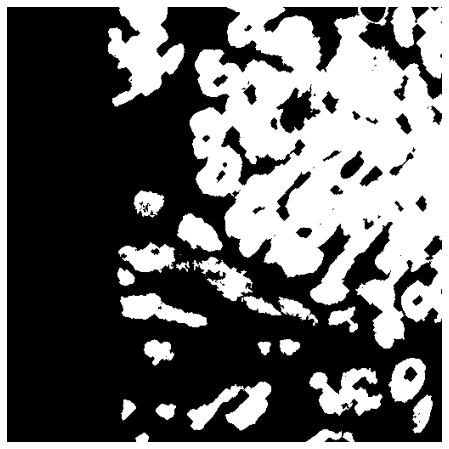

In [7]:
#### Otsu thrsholding the CK8 image to get a preliminary epithlium mask

# Otsu thrsholding level by level
otsu_offset = -10 #set offset is necessary, higher value = more included
stack_thrs = np.zeros(stack_ds.shape, dtype = np.uint8)
for frame_idx in tqdm(range(stack_thrs.shape[0])):
    
    cur_frame = stack_edgenh[frame_idx]
    
    if np.count_nonzero(cur_frame)>100: #only threshold if the level contains enough foreground
        thresh = filters.threshold_otsu(stack_edgenh[frame_idx])
        otsu = stack_edgenh[frame_idx] > (thresh - otsu_offset)
        
        # Minor adjustments to the epitheliums
        fill_s = morphology.remove_small_holes(otsu ,50)
        fill_s = morphology.remove_small_objects(fill_s, 80)
        
        stack_thrs[frame_idx] = fill_s.astype(np.uint8)*255
        
    else:
        stack_thrs[frame_idx] = 0

        
# Connect the gaps in epithelium masks (with closing) [optional]
pad_width = 5 # This is also the iterations for closing (dilation + erosion)
stack_thrs = np.pad(stack_thrs, pad_width, mode='constant') # Add padding to fix edge frames
stack_thrs = ndi.morphology.binary_closing(stack_thrs,iterations=pad_width).astype(np.uint8)*255
stack_thrs = stack_thrs[pad_width:-pad_width, pad_width:-pad_width, pad_width:-pad_width]

# Save the preliminary epithelium mask
image_show(stack_thrs[stack_thrs.shape[0]//2][4312:4824,:])
imsave(stack_path +'_otsuthrsh.tif',stack_thrs[:,4312:4824,:])

## 2. Obtain preliminary the lumen mask based on space enclosed by the epithelium mask

100%|████████████████████████████████████████████████████████████████████████████████| 364/364 [02:47<00:00,  2.17it/s]


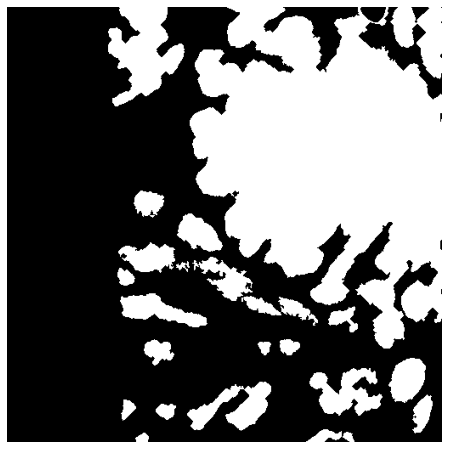

100%|████████████████████████████████████████████████████████████████████████████████| 512/512 [02:57<00:00,  2.88it/s]


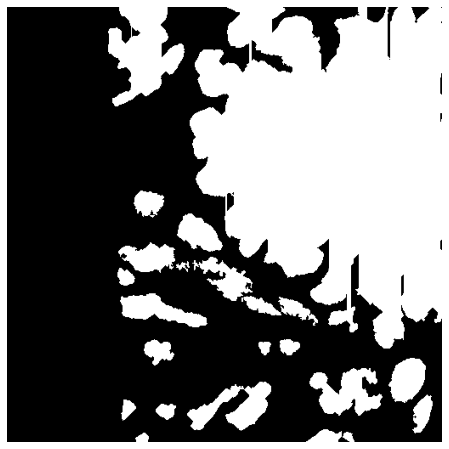

100%|████████████████████████████████████████████████████████████████████████████████| 364/364 [00:59<00:00,  6.12it/s]


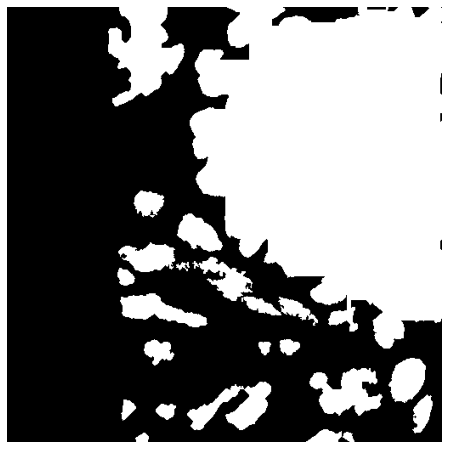

In [8]:
#### To obtain lumen mask, fill holes enclosed by the epithelium masks (from 3 directions)
#### Operation order: largest cross-section to smallest cross section


# Fill holes + remove small objects level-by-level from top view
fill_hole1 = np.zeros(stack_thrs.shape,dtype = np.uint8)
for frame_idx in tqdm(range(fill_hole1.shape[0])):
    fill_hole = fill_hole_2edge_2corner(stack_thrs[frame_idx, :, :])
    fill_hole1[frame_idx] = morphology.remove_small_objects(fill_hole, 5).astype(np.uint8)    
fill_hole1 = (fill_hole1*255).astype(np.uint8)
image_show(fill_hole1[fill_hole1.shape[0]//2][4312:4824,:])
imsave(stack_path +'_fill_hole1.tif',fill_hole1[:,4312:4824,:]) # Save current fill-hole result


# Fill holes + remove small objects level-by-level from side view
fill_hole2 = np.zeros(stack_thrs.shape,dtype = np.uint8)
for frame_idx in tqdm(range(fill_hole2.shape[2])):
    fill_hole = fill_hole_2edge_2corner(fill_hole1[:,:, frame_idx])
    fill_hole2[:, :, frame_idx] = morphology.remove_small_objects(fill_hole, 5).astype(np.uint8)   
fill_hole2 = (fill_hole2*255).astype(np.uint8)
image_show(fill_hole2[fill_hole2.shape[0]//2][4312:4824,:])
imsave(stack_path +'_fill_hole2.tif',fill_hole2[:,4312:4824,:]) # Save current fill-hole result


# Fill holes +remove small objects level-by-level from front view
fill_hole3 = np.zeros(stack_thrs.shape,dtype = np.uint8)
for frame_idx in tqdm(range(fill_hole3.shape[1])):
    fill_hole = fill_hole_add_edge(fill_hole2[:,frame_idx,:])
    fill_hole3[:, frame_idx, :] = morphology.remove_small_objects(fill_hole, 5).astype(np.uint8)
fill_hole3 = (fill_hole3*255).astype(np.uint8)
# image_show(fill_hole3[fill_hole3.shape[0]//2]) # Save current fill-hole result


# For replenishment, fill holes + remove small objects level-by-level from top view again [optional]
for frame_idx in tqdm(range(fill_hole3.shape[0])):
    fill_hole = ndi.morphology.binary_fill_holes(fill_hole3[frame_idx,:,:])
    fill_hole3[frame_idx,:,:] = morphology.remove_small_objects(fill_hole, 5).astype(np.uint8)*255
image_show(fill_hole3[fill_hole3.shape[0]//2][4312:4824,:])
imsave(stack_path +'_fill_hole3.tif',fill_hole3[:,4312:4824,:]) # Save current fill-hole result

## 3. Introduce information from cytoplasm to obain a preliminary tissue mask to refine the lumen mask with

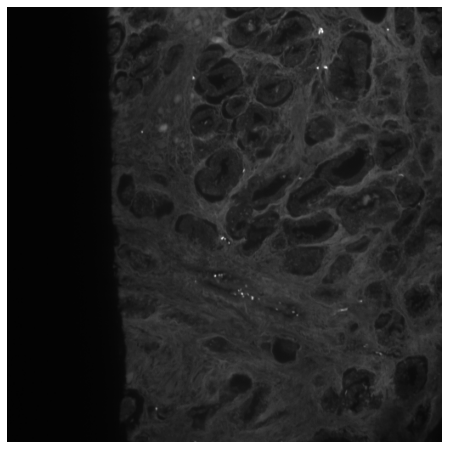

cyto.shape (727, 12544, 1024)
cyto_ds.shape (364, 6272, 512)


In [9]:
#### Import cytoplasm channel and downsample

# Read cytoplasm image
cyto_dir = full_seq_dir+'\\Fused_dod_'+block_name+'\\ch2\\'+block_name+'_ch2.tif' # Directory to the cyto image file
cyto = io.imread(cyto_dir)

# Downsample cytoplasm by 2X
cyto_ds = block_reduce(cyto, block_size=(ds_time, ds_time, ds_time), func=np.mean).astype(np.uint8)
image_show(cyto_ds[cyto_ds.shape[0]//2][4312:4824,:]);

# Save the downsampled cytoplasm image
cyto_save_path = cyto_dir[:-4]
imsave(cyto_save_path+'_ds'+str(ds_time)+'.tif', cyto_ds[:,4312:4824,:])
print('cyto.shape', cyto.shape)
print('cyto_ds.shape', cyto_ds.shape)

del cyto # Once downsampled, free memory by deleting the original-resolution cytoplasm image

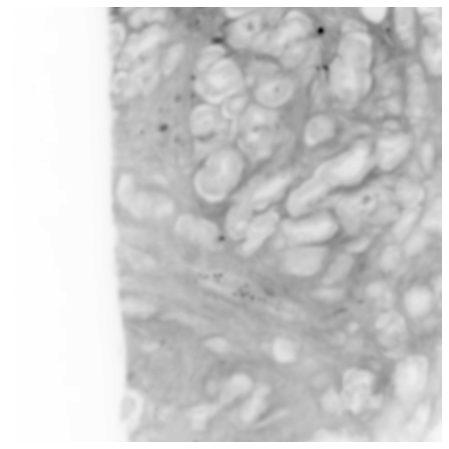

  0%|                                                                                          | 0/370 [00:00<?, ?it/s]C:\Users\ADMINI~1\AppData\Local\Temp\2/ipykernel_12644/2385896651.py:44: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  cyto_thrs_close[frame_idx] = (morphology.remove_small_holes(cyto_thrs_close[frame_idx], area_threshold=200)).astype(np.uint8)*255
100%|████████████████████████████████████████████████████████████████████████████████| 370/370 [00:26<00:00, 14.12it/s]


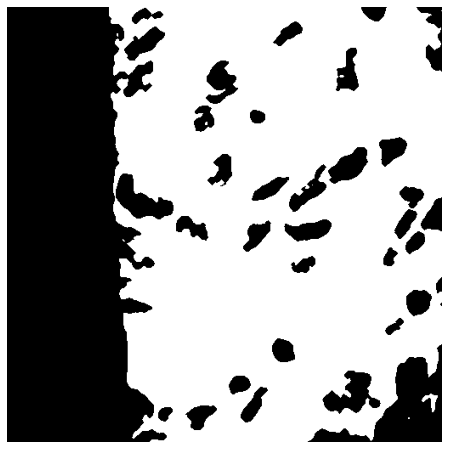

uint8


In [10]:
#### Obtain preliminary tissue mask with cytoplasm channel

# Preprocess cytoplasm: guassian bluring
cyto_pre = ndi.gaussian_filter(cyto_ds+1, sigma=2).astype(np.uint8)*255 
image_show(cyto_pre[cyto_pre.shape[0]//2][4312:4824,:])
imsave(cyto_save_path +'_preprocess.tif',cyto_pre[:,4312:4824,:])

# Get preliminary tissue mask by otsu thresholding the blurred cytoplasm channel level-by-level
cyto_thrs = np.zeros(cyto_ds.shape, dtype = np.uint8)
otsu_offset = 5 # Set offset if necessary, use larger value to include less into cyto mask
for frame_idx in tqdm(range(cyto_ds.shape[0])):
    cur_frame = cyto_pre[frame_idx]
    if np.count_nonzero(cur_frame)>50: # Only threshold if the level contains enough foreground
        
#         # Optional step: add CLAHE to cyto
#         clahe = cv2.createCLAHE(clipLimit = 10.0, tileGridSize=(5,5))
#         cur_frame = clahe.apply(cur_frame)
        
        thresh = filters.threshold_otsu(cur_frame)
        otsu = cur_frame < (thresh - otsu_offset)  
        cyto_thrs[frame_idx] = otsu.astype(np.uint8)*255
    else:
        cyto_thrs[frame_idx] = 0
        
# Save the thresholded tissue mask
imsave(cyto_save_path +'_thrs.tif',cyto_thrs[:,4312:4824,:])


#### Minor adjustment to the preliminary tissue mask

# Connect gaps with closing
pad_width = 3
cyto_thrs = np.pad(cyto_thrs, pad_width, mode='constant') # Add padding to fix edge levels
cyto_thrs_close = ndi.morphology.binary_closing(cyto_thrs,iterations=pad_width) 

# Remove small 3D holes
cyto_thrs_close = (morphology.remove_small_holes(cyto_thrs_close, area_threshold=8000)).astype(np.uint8)*255

# Remove small 3D objects (noise)
cyto_thrs_close = (morphology.remove_small_objects(cyto_thrs_close, min_size=50000)).astype(np.uint8)*255

# Remove small 2D holes level-by-level
for frame_idx in tqdm(range(cyto_thrs_close.shape[0])):
    cyto_thrs_close[frame_idx] = (morphology.remove_small_holes(cyto_thrs_close[frame_idx], area_threshold=200)).astype(np.uint8)*255

cyto_thrs_close = cyto_thrs_close[pad_width:-pad_width, pad_width:-pad_width, pad_width:-pad_width]
image_show(cyto_thrs_close[cyto_thrs_close.shape[0]//2][4312:4824,:])
print(cyto_thrs_close.dtype)

# Save the preliminary tissue mask after adjustments
imsave(cyto_save_path +'_thrs_close.tif',cyto_thrs_close[:,4312:4824,:])

## 4. Exclude lumen-overlapping region in the tissue mask

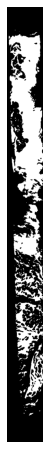

In [11]:
### Separate parts in tissue mask inside and outside lumen

# Tissue mask - epithelium mask
cyto_minus_epi = np.bitwise_and(cyto_thrs_close.astype(bool), np.invert(stack_thrs.astype(bool)))

# Further separate parts inside the outside glands in the tissue mask with opening
open_iter = 2 #adjust this value according to the following rules:
# use bigger opening size for more separated volumes to find lumen when cyto signal is heavily seen in lumens (e.g. 7)
# use smaller values (e.g. 2 or even 0) if the glands are small and crowded

# cyto_minus_epi = ndi.morphology.binary_opening(cyto_minus_epi,iterations=open_iter)
cyto_minus_epi = ndi.morphology.binary_opening(cyto_minus_epi,structure = morphology.ball(open_iter), iterations=1)
vimg_show(cyto_minus_epi)
imsave(stack_path + '_cyto_minus_epi.tif', (cyto_minus_epi.astype(np.uint8)*255)[:,4312:4824,:])

# Label the separate volume in the result
cyto_minus_epi_labels = measure.label(cyto_minus_epi, background=0)
imsave(stack_path + '_cyto_minus_epi_labels.tif',cyto_minus_epi_labels.astype(np.uint8)[:,4312:4824,:])

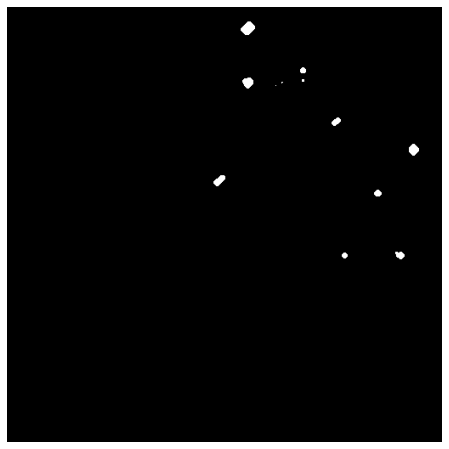

In [12]:
#### Find lumen-overlapping region in tissue mask

# Find small individual volume (without holes) - likely resulted from cytoplasm signal in lumen
remov_lumen = morphology.remove_small_objects(cyto_minus_epi, min_size = 1000000) # min_size = max size of cyto in lumen
find_lumen = np.bitwise_and(cyto_minus_epi.astype(bool), np.invert(remov_lumen.astype(bool)))
find_lumen = morphology.remove_small_objects(find_lumen.astype(bool), min_size = 100) # Get rid of too small objects

# Enlarge (dilate) the lumen-overlapping region to makes sure they touch the epithelium
pad_width = 5
find_lumen = np.pad(find_lumen, pad_width, mode='constant')
for idx in range(pad_width):
    find_lumen = morphology.binary_dilation(find_lumen)
find_lumen = find_lumen[pad_width:-pad_width, pad_width:-pad_width, pad_width:-pad_width]

image_show(find_lumen[find_lumen.shape[0]//2][4312:4824,:])

# Save the lumen-overlapping region in tissue mask
imsave(stack_path + '_find_lumen_in_cyto.tif', (find_lumen.astype(np.uint8)*255)[:,4312:4824,:])

100%|████████████████████████████████████████████████████████████████████████████████| 364/364 [00:22<00:00, 16.10it/s]


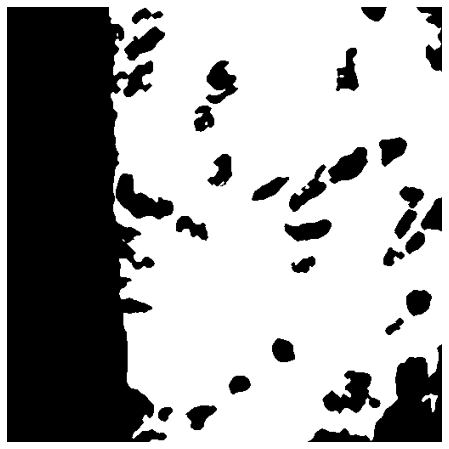

In [13]:
#### Refine tissue mask by exluding lumen-overlapping region

# Preliminary tissue mask - lumen-overlapping region
tissue_mask = np.bitwise_and(cyto_thrs_close.astype(bool), np.invert(find_lumen.astype(bool)))

# Remove small holes in tissue mask
tissue_mask = morphology.remove_small_holes(tissue_mask.astype(bool), area_threshold=8000)
for frame_idx in tqdm(range(tissue_mask.shape[0])):
    tissue_mask[frame_idx] = morphology.remove_small_holes(tissue_mask[frame_idx], area_threshold=200)

# Remove small objects in tissue mask
tissue_mask = morphology.remove_small_objects(tissue_mask.astype(bool), min_size = 200)
image_show(tissue_mask[tissue_mask.shape[0]//2][4312:4824,:])

# Save the final tissue mask
imsave(stack_path + '_tissue_mask.tif', (tissue_mask.astype(np.uint8)*255)[:,4312:4824,:])

## 5. Refine lumen with the tissue mask

number of objects: 35864


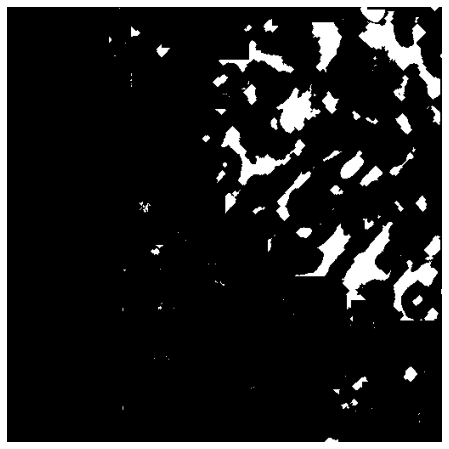

number of objects: 12872


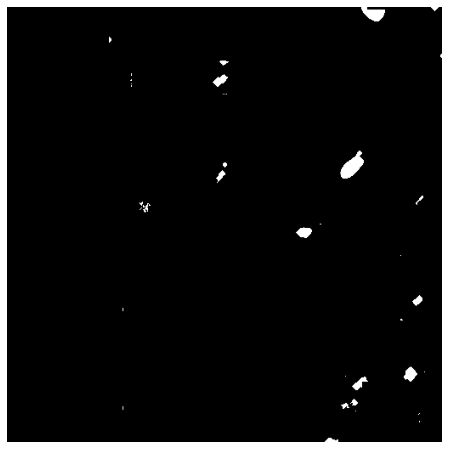

In [14]:
#### Refine lumen mask by exluding regions overlapping with tissue mask 
#### Compare the number of individual objects in lumen mask before and after refinement

# Get lumen volumes by excluding epithelium mask from filled-in gland mask
add_vol = np.bitwise_and(fill_hole3,np.invert(stack_thrs))
add_vol_labels = measure.label(add_vol, background=0) # Count number of objects in lumen mask
print('number of objects:',add_vol_labels.max())
image_show(add_vol[add_vol.shape[0]//2][4312:4824,:])

# Refine lumen mask by exluding regions overlapping with tissue mask 
add_vol_E = np.bitwise_and(add_vol ,np.invert(tissue_mask))
add_vol_labels = measure.label(add_vol_E, background=0) # Count number of objects in lumen mask
print('number of objects:',add_vol_labels.max())
image_show(add_vol_E[add_vol_E.shape[0]//2][4312:4824,:])

# Save the labeled lumen mask
imsave(stack_path + '_add_vol_E_labels.tif',add_vol_labels.astype(np.uint8)[:,4312:4824,:])

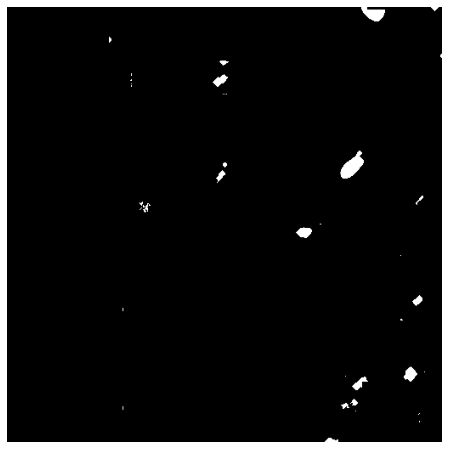

100%|████████████████████████████████████████████████████████████████████████████████| 364/364 [00:26<00:00, 13.68it/s]


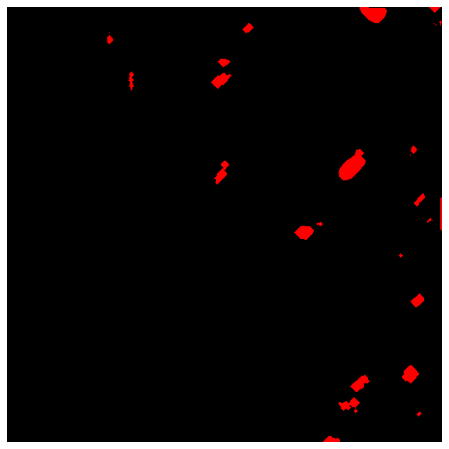

In [15]:
### Minor adjustments for final lumen mask

# Get binary mask for lumen
dil_lumen = add_vol_labels>0
image_show(dil_lumen[dil_lumen.shape[0]//2][4312:4824,:])

# Enlarge the lumen mask for a little bit to account for edge layers
dil_lumen = ndi.morphology.binary_dilation(dil_lumen,iterations=2)

# Make sure lumens volumes are hole-free
dil_lumen = ndi.morphology.binary_fill_holes(dil_lumen)

# Remove small gaps in lumen
for frame_idx in tqdm(range(dil_lumen.shape[0])):
    fill_hole = dil_lumen[frame_idx,:,:]
    dil_lumen[frame_idx,:,:] = morphology.remove_small_holes(fill_hole, 2500).astype(np.uint8)*255

# Remove small objects in lumen mask (reduce noice)
dil_lumen = morphology.remove_small_objects(dil_lumen, 800)
color_dil_lumen = np.zeros((dil_lumen.shape[0],dil_lumen.shape[1],dil_lumen.shape[2],3), dtype="uint8")
color_dil_lumen[:, :, :, 0] = dil_lumen*255
image_show(color_dil_lumen[dil_lumen.shape[0]//2][4312:4824,:,:])

# Save the final lumen mask
imsave(stack_path + '_dil_lumen.tif', color_dil_lumen[:,4312:4824,:,:])

## 6. Refine gland volumes (epithlium + lumen) and get the final epithelium mask

100%|████████████████████████████████████████████████████████████████████████████████| 512/512 [00:53<00:00,  9.56it/s]


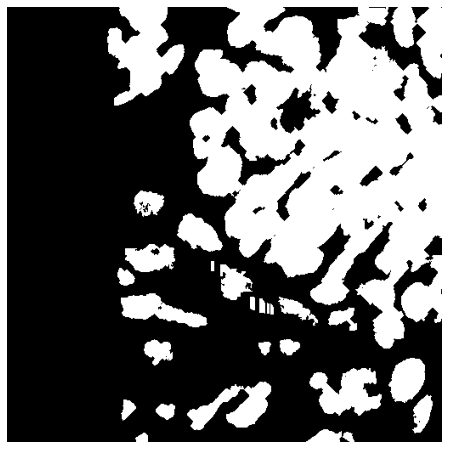

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [16]:
#### Refine gland volumes volumes

# Obtain preliminary gland mask by combining lumen and epithlium masks
combine_epi_lum = np.bitwise_or(stack_thrs.astype(bool), dil_lumen)
combine_epi_lum = ndi.morphology.binary_fill_holes(combine_epi_lum)

# Refine the gland mask by removing small objects level-by-level from 3 directions

# From top view
glands_1 = np.zeros(combine_epi_lum.shape, dtype = bool)
for frame_idx in tqdm(range(combine_epi_lum.shape[0])):
    cur_frame = combine_epi_lum[frame_idx].astype(bool)
    glands_1[frame_idx] = morphology.remove_small_objects(cur_frame, 50)

# From side view
glands_2 = np.zeros(combine_epi_lum.shape, dtype = bool)
for frame_idx in tqdm(range(combine_epi_lum.shape[1])): 
    cur_frame = glands_1[:,frame_idx,:].astype(bool)
    glands_2[:,frame_idx,:] = morphology.remove_small_objects(cur_frame, 50)

# From front view 
glands_3 = np.zeros(combine_epi_lum.shape, dtype = bool)
for frame_idx in tqdm(range(combine_epi_lum.shape[2])): 
    cur_frame = glands_2[:,:, frame_idx].astype(bool)
    glands_3[:,:, frame_idx] = morphology.remove_small_objects(cur_frame, 50)
image_show(glands_3[glands_3.shape[0]//2][4312:4824,:]) 

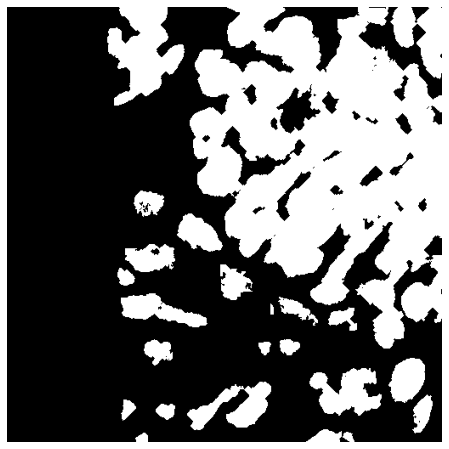

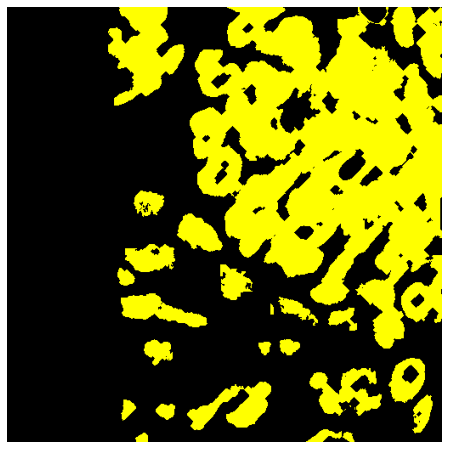

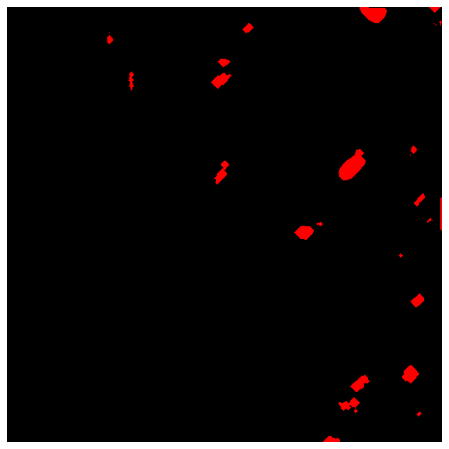

In [17]:
#### Get final gland mask and derive final epithelium mask 

# Remove small volumes in the gland mask (reduce noise)
glands = morphology.remove_small_objects(glands_3, 1000).astype(np.uint8)
image_show(glands[glands.shape[0]//2][4312:4824,:])

# Save the final gland mask
imsave(stack_path + '_glands.tif',((glands.astype(np.uint8))*255)[:,4312:4824,:])

# Derive the final epithelium mask by exluding final lumen mask from final gland mask
epi_layer = np.bitwise_and(glands.astype(bool), np.invert(dil_lumen.astype(bool)))
color_epi_layer = np.zeros((epi_layer.shape[0],epi_layer.shape[1],epi_layer.shape[2],3), dtype="uint8")
color_epi_layer[:, :, :, 0] = epi_layer*255
color_epi_layer[:, :, :, 1] = epi_layer*255

# Save the final epithelium mask
image_show(color_epi_layer[epi_layer.shape[0]//2][4312:4824,:,:])
image_show(color_dil_lumen[dil_lumen.shape[0]//2][4312:4824,:,:])
imsave(stack_path + '_epi_layer.tif',color_epi_layer[:,4312:4824,:,:])

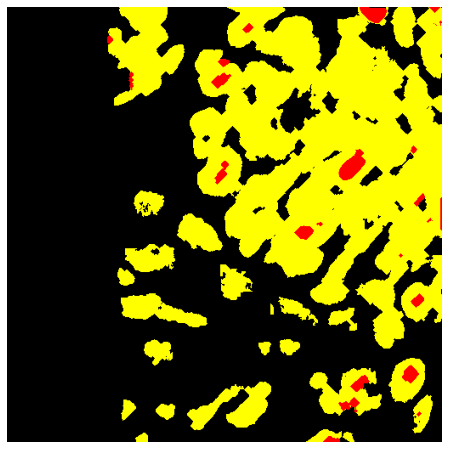

In [18]:
color_gland = np.zeros((epi_layer.shape[0],epi_layer.shape[1],epi_layer.shape[2],3), dtype="uint8")
color_gland = color_epi_layer + color_dil_lumen
image_show(color_gland[color_gland.shape[0]//2][4312:4824,:,:])
imsave(stack_path + '_color_gland.tif',color_gland[:,4312:4824,:,:])